In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 194
TIMESTEPS = 1
EPOCH=200
BATCH_SIZE=100

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

# METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

DATASET_DIR_NAME = "dataset\set03\\12_pair_IRDR"
SAMPLE_DATASET_NAME = "pair_train_IRDR"
# ACTUAL_DATASET_NAME = "pair_test_" + METHOD

MODEL_DIR_NAME = "dataset\set03\\12_pair_IRDR"
MODEL_NAME = "model_" + "set03_12_pair_IRDR"

# RESULT_DIR_NAME = "dataset\set03\\12_pair_IRDR"
# RESULT_NAME = "result_" + "set03_12_pair_" + METHOD

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
# ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

# RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
# RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\12_pair_IRDR
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\12_pair_IRDR
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set03\12_pair_IRDR\pair_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR.1,T4-NG|VAR.1,T4-I|SD.1,T4-PF|SD.1,T4-RF|SD.1,T4-NG|SD.1,T5-I|0+4.1,T5-PF|0+4.1,T5-RF|0+4.1,T5-NG|0+4.1
0,adhy,wench,0.152282,-0.073436,0.078847,0.088479,0.240761,0.161915,0.10287,0.264785,...,0.010378,7.121751e-03,0.073101,0.055621,0.101870,0.084390,0.512567,0.624480,0.608445,0.720359
1,adhy,wench,0.152282,-0.073436,0.078847,0.088479,0.240761,0.161915,0.10287,0.264785,...,0.027081,2.177609e-02,0.159465,0.142471,0.164562,0.147567,0.343992,0.488168,0.464252,0.608427
2,adhy,wench,0.152282,-0.073436,0.078847,0.088479,0.240761,0.161915,0.10287,0.264785,...,0.000021,2.665160e-04,0.012384,0.000596,0.004537,0.016325,0.215807,0.368583,0.318909,0.471685
3,adhy,wench,0.152282,-0.073436,0.078847,0.088479,0.240761,0.161915,0.10287,0.264785,...,0.018517,7.202189e-03,0.141381,0.090169,0.136078,0.084866,0.441357,0.512098,0.553000,0.623741
4,adhy,wench,0.152282,-0.073436,0.078847,0.088479,0.240761,0.161915,0.10287,0.264785,...,0.000297,1.120000e-07,0.080601,0.063019,0.017246,0.000335,0.456564,0.592843,0.519370,0.655649


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


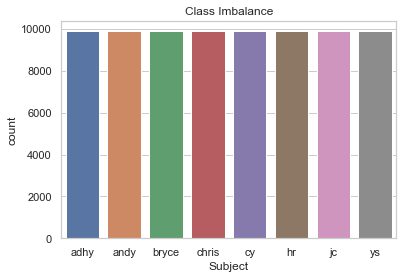

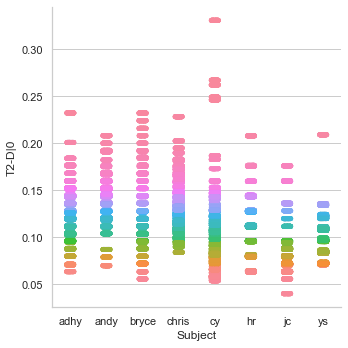

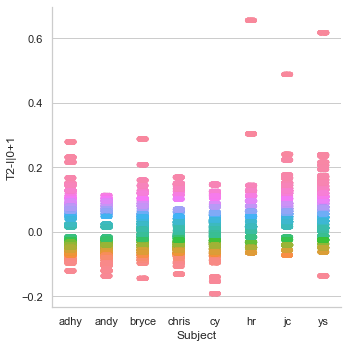

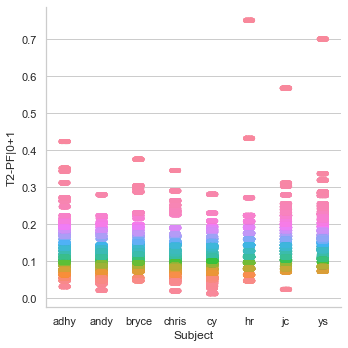

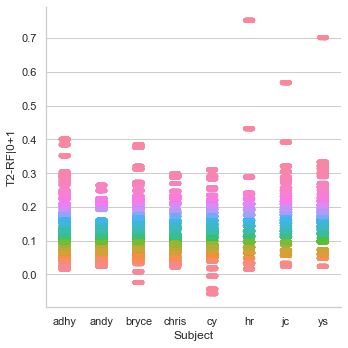

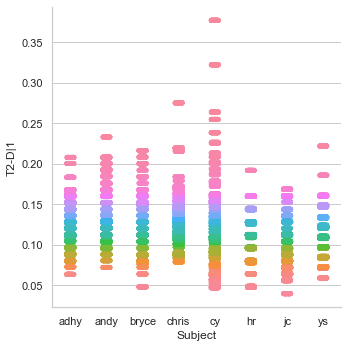

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (79200, 194)
Y | Classes  | Dataset Shape: (79200, 8)
Number of Classes: 8


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (63360, 1, 194)
Y train shape: (63360, 8)
X test shape: (15840, 1, 194)
Y test shape: (15840, 8)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 8 classes.
Epoch 1/200
507/507 [==============================] - 13s 14ms/step - loss: 1.7663 - accuracy: 0.2683
Epoch 2/200
507/507 [==============================] - 7s 14ms/step - loss: 1.4522 - accuracy: 0.3780
Epoch 3/200
507/507 [==============================] - 8s 15ms/step - loss: 1.3732 - accuracy: 0.4013
Epoch 4/200
507/507 [==============================] - 7s 14ms/step - loss: 1.2545 - accuracy: 0.4996
Epoch 5/200
507/507 [==============================] - 7s 14ms/step - loss: 1.1915 - accuracy: 0.5202
Epoch 6/200
507/507 [==============================] - 7s 14ms/step - loss: 1.1632 - accuracy: 0.5316
Epoch 7/200
507/507 [==============================] - 7s 14ms/step - loss: 1.1309 - accuracy: 0.5483
Epoch 8/200
507/507 [==============================] - 7s 14ms/step - loss: 1.0943 - accuracy: 0.5744
Epoch 9/200
507/507 [==============================] - 7s 14ms/step - loss: 1.0542 - accuracy: 0.5968
Epoch 10/200
507/507 [===========================

507/507 [==============================] - 8s 15ms/step - loss: 0.0882 - accuracy: 0.9742
Epoch 81/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0897 - accuracy: 0.9736
Epoch 82/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0863 - accuracy: 0.9746
Epoch 83/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0785 - accuracy: 0.9763
Epoch 84/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0751 - accuracy: 0.9782
Epoch 85/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0824 - accuracy: 0.9758
Epoch 86/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0711 - accuracy: 0.9802
Epoch 87/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0649 - accuracy: 0.9812
Epoch 88/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0744 - accuracy: 0.9788
Epoch 89/200
507/507 [==============================] - 7s 15ms/step - loss: 0.0601 - 

507/507 [==============================] - 8s 15ms/step - loss: 0.0359 - accuracy: 0.9905
Epoch 160/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0122 - accuracy: 0.9966
Epoch 161/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0211 - accuracy: 0.9948
Epoch 162/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0230 - accuracy: 0.9936
Epoch 163/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0251 - accuracy: 0.9935
Epoch 164/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0223 - accuracy: 0.9944
Epoch 165/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0156 - accuracy: 0.9959
Epoch 166/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0191 - accuracy: 0.9953
Epoch 167/200
507/507 [==============================] - 8s 15ms/step - loss: 0.0297 - accuracy: 0.9920
Epoch 168/200
507/507 [==============================] - 8s 15ms/step - loss: 

507/507 [==============================] - 8s 16ms/step - loss: 0.3618 - accuracy: 0.8762
Epoch 38/200
507/507 [==============================] - 8s 16ms/step - loss: 0.3563 - accuracy: 0.8804
Epoch 39/200
507/507 [==============================] - 8s 16ms/step - loss: 0.3409 - accuracy: 0.8851
Epoch 40/200
507/507 [==============================] - 8s 16ms/step - loss: 0.3359 - accuracy: 0.8871
Epoch 41/200
507/507 [==============================] - 8s 16ms/step - loss: 0.3250 - accuracy: 0.8920
Epoch 42/200
507/507 [==============================] - 8s 16ms/step - loss: 0.3108 - accuracy: 0.8958
Epoch 43/200
507/507 [==============================] - 8s 16ms/step - loss: 0.2938 - accuracy: 0.9016
Epoch 44/200
507/507 [==============================] - 8s 16ms/step - loss: 0.2937 - accuracy: 0.9035
Epoch 45/200
507/507 [==============================] - 8s 16ms/step - loss: 0.2871 - accuracy: 0.9050
Epoch 46/200
507/507 [==============================] - 8s 16ms/step - loss: 0.2731 - 

507/507 [==============================] - 9s 17ms/step - loss: 0.0798 - accuracy: 0.9756
Epoch 117/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0796 - accuracy: 0.9751
Epoch 118/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0811 - accuracy: 0.9758
Epoch 119/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0741 - accuracy: 0.9774
Epoch 120/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0718 - accuracy: 0.9778
Epoch 121/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0717 - accuracy: 0.9780
Epoch 122/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0797 - accuracy: 0.9756
Epoch 123/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0801 - accuracy: 0.9750
Epoch 124/200
507/507 [==============================] - 9s 17ms/step - loss: 0.0803 - accuracy: 0.9760
Epoch 125/200
507/507 [==============================] - 9s 17ms/step - loss: 

507/507 [==============================] - 9s 18ms/step - loss: 0.0438 - accuracy: 0.9873
Epoch 195/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0440 - accuracy: 0.9875
Epoch 196/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0409 - accuracy: 0.9874
Epoch 197/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0425 - accuracy: 0.9872
Epoch 198/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0445 - accuracy: 0.9869
Epoch 199/200
507/507 [==============================] - 9s 18ms/step - loss: 0.0459 - accuracy: 0.9871
Epoch 200/200
127/127 [==============================] - 2s 7ms/step - loss: 0.3514 - accuracy: 0.9262
There are a total of 8 classes.
Epoch 1/200
507/507 [==============================] - 16s 19ms/step - loss: 1.7853 - accuracy: 0.2632
Epoch 2/200
507/507 [==============================] - 10s 19ms/step - loss: 1.4450 - accuracy: 0.4050
Epoch 3/200
507/507 [============================

507/507 [==============================] - 10s 20ms/step - loss: 0.1521 - accuracy: 0.9500
Epoch 72/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1501 - accuracy: 0.9519
Epoch 73/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1406 - accuracy: 0.9543
Epoch 74/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1396 - accuracy: 0.9550
Epoch 75/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1383 - accuracy: 0.9561
Epoch 76/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1379 - accuracy: 0.9545
Epoch 77/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1314 - accuracy: 0.9576
Epoch 78/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1326 - accuracy: 0.9572
Epoch 79/200
507/507 [==============================] - 10s 20ms/step - loss: 0.1314 - accuracy: 0.9587
Epoch 80/200
507/507 [==============================] - 10s 20ms/step - loss:

507/507 [==============================] - 11s 21ms/step - loss: 0.0576 - accuracy: 0.9825
Epoch 150/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0576 - accuracy: 0.9831
Epoch 151/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0562 - accuracy: 0.9829
Epoch 152/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0577 - accuracy: 0.9829
Epoch 153/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0586 - accuracy: 0.9827
Epoch 154/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0578 - accuracy: 0.9828
Epoch 155/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0590 - accuracy: 0.9824
Epoch 156/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0552 - accuracy: 0.9830
Epoch 157/200
507/507 [==============================] - 11s 21ms/step - loss: 0.0575 - accuracy: 0.9819
Epoch 158/200
507/507 [==============================] - 11s 21ms/ste

507/507 [==============================] - 12s 23ms/step - loss: 0.5619 - accuracy: 0.8041
Epoch 27/200
507/507 [==============================] - 11s 22ms/step - loss: 0.5484 - accuracy: 0.8090
Epoch 28/200
507/507 [==============================] - 11s 22ms/step - loss: 0.5215 - accuracy: 0.8181
Epoch 29/200
507/507 [==============================] - 12s 23ms/step - loss: 0.5070 - accuracy: 0.8256
Epoch 30/200
507/507 [==============================] - 12s 24ms/step - loss: 0.4827 - accuracy: 0.8348
Epoch 31/200
507/507 [==============================] - 14s 27ms/step - loss: 0.4683 - accuracy: 0.8399
Epoch 32/200
507/507 [==============================] - 13s 26ms/step - loss: 0.4533 - accuracy: 0.8446
Epoch 33/200
507/507 [==============================] - 14s 27ms/step - loss: 0.4386 - accuracy: 0.8503
Epoch 34/200
507/507 [==============================] - 13s 27ms/step - loss: 0.4161 - accuracy: 0.8600
Epoch 35/200
507/507 [==============================] - 14s 27ms/step - loss:

507/507 [==============================] - 14s 28ms/step - loss: 0.0878 - accuracy: 0.9726
Epoch 105/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0829 - accuracy: 0.9753
Epoch 106/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0829 - accuracy: 0.9749
Epoch 107/200
507/507 [==============================] - 16s 31ms/step - loss: 0.0890 - accuracy: 0.9723
Epoch 108/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0842 - accuracy: 0.9733
Epoch 109/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0796 - accuracy: 0.9756
Epoch 110/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0832 - accuracy: 0.9743
Epoch 111/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0743 - accuracy: 0.9775
Epoch 112/200
507/507 [==============================] - 14s 28ms/step - loss: 0.0802 - accuracy: 0.9753
Epoch 113/200
507/507 [==============================] - 14s 28ms/ste

507/507 [==============================] - 14s 29ms/step - loss: 0.0291 - accuracy: 0.9920
Epoch 183/200
507/507 [==============================] - 14s 29ms/step - loss: 0.0293 - accuracy: 0.9913
Epoch 184/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0300 - accuracy: 0.9915
Epoch 185/200
507/507 [==============================] - 14s 29ms/step - loss: 0.0330 - accuracy: 0.9909
Epoch 186/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0315 - accuracy: 0.9914
Epoch 187/200
507/507 [==============================] - 14s 29ms/step - loss: 0.0323 - accuracy: 0.9908
Epoch 188/200
507/507 [==============================] - 14s 29ms/step - loss: 0.0311 - accuracy: 0.9908
Epoch 189/200
507/507 [==============================] - 15s 30ms/step - loss: 0.0303 - accuracy: 0.9914
Epoch 190/200
507/507 [==============================] - 15s 29ms/step - loss: 0.0306 - accuracy: 0.9915
Epoch 191/200
507/507 [==============================] - 14s 29ms/ste

507/507 [==============================] - 16s 31ms/step - loss: 0.2082 - accuracy: 0.9307
Epoch 60/200
507/507 [==============================] - 16s 32ms/step - loss: 0.2082 - accuracy: 0.9318
Epoch 61/200
507/507 [==============================] - 16s 32ms/step - loss: 0.2010 - accuracy: 0.9352
Epoch 62/200
507/507 [==============================] - 17s 33ms/step - loss: 0.1950 - accuracy: 0.9362
Epoch 63/200
507/507 [==============================] - 17s 33ms/step - loss: 0.1838 - accuracy: 0.9416
Epoch 64/200
507/507 [==============================] - 16s 32ms/step - loss: 0.1900 - accuracy: 0.9389
Epoch 65/200
507/507 [==============================] - 17s 33ms/step - loss: 0.1850 - accuracy: 0.9398
Epoch 66/200
507/507 [==============================] - 17s 33ms/step - loss: 0.1735 - accuracy: 0.9431
Epoch 67/200
507/507 [==============================] - 17s 33ms/step - loss: 0.1741 - accuracy: 0.9414
Epoch 68/200
507/507 [==============================] - 16s 31ms/step - loss:

507/507 [==============================] - 17s 33ms/step - loss: 0.0340 - accuracy: 0.9911
Epoch 138/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0303 - accuracy: 0.9915
Epoch 139/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0321 - accuracy: 0.9915
Epoch 140/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0239 - accuracy: 0.9930
Epoch 141/200
507/507 [==============================] - 17s 34ms/step - loss: 0.0236 - accuracy: 0.9935
Epoch 142/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0313 - accuracy: 0.9917
Epoch 143/200
507/507 [==============================] - 17s 34ms/step - loss: 0.0260 - accuracy: 0.9926
Epoch 144/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0260 - accuracy: 0.9928
Epoch 145/200
507/507 [==============================] - 17s 33ms/step - loss: 0.0280 - accuracy: 0.9926
Epoch 146/200
507/507 [==============================] - 16s 32ms/ste

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 98.20% (with standard deviation of 2.80%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 8 classes.
Epoch 1/200
634/634 [==============================] - 27s 33ms/step - loss: 1.7111 - accuracy: 0.2842
Epoch 2/200
634/634 [==============================] - 21s 33ms/step - loss: 1.4085 - accuracy: 0.4144
Epoch 3/200
634/634 [==============================] - 22s 34ms/step - loss: 1.2480 - accuracy: 0.4963
Epoch 4/200
634/634 [==============================] - 21s 32ms/step - loss: 1.1946 - accuracy: 0.5179
Epoch 5/200
634/634 [==============================] - 21s 34ms/step - loss: 1.1537 - accuracy: 0.5309
Epoch 6/200
634/634 [==============================] - 21s 34ms/step - loss: 1.1187 - accuracy: 0.5531
Epoch 7/200
634/634 [==============================] - 22s 34ms/step - loss: 1.0659 - accuracy: 0.6038
Epoch 8/200
634/634 [==============================] - 20s 32ms/step - loss: 1.0051 - accuracy: 0.6368
Epoch 9/200
634/634 [==============================] - 21s 34ms/step - loss: 0.9686 - accuracy: 0.6491
Epoch 10/200
634/634 [===================

634/634 [==============================] - 22s 35ms/step - loss: 0.0986 - accuracy: 0.9691
Epoch 80/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0916 - accuracy: 0.9717
Epoch 81/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0966 - accuracy: 0.9700
Epoch 82/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0955 - accuracy: 0.9707
Epoch 83/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0942 - accuracy: 0.9703
Epoch 84/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0907 - accuracy: 0.9715
Epoch 85/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0899 - accuracy: 0.9714
Epoch 86/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0912 - accuracy: 0.9713
Epoch 87/200
634/634 [==============================] - 22s 35ms/step - loss: 0.0885 - accuracy: 0.9723
Epoch 88/200
634/634 [==============================] - 22s 35ms/step - loss:

634/634 [==============================] - 23s 36ms/step - loss: 0.0466 - accuracy: 0.9864
Epoch 158/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0452 - accuracy: 0.9868
Epoch 159/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0434 - accuracy: 0.9870
Epoch 160/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0484 - accuracy: 0.9856
Epoch 161/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0427 - accuracy: 0.9869
Epoch 162/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0391 - accuracy: 0.9881
Epoch 163/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0412 - accuracy: 0.9871
Epoch 164/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0443 - accuracy: 0.9871
Epoch 165/200
634/634 [==============================] - 23s 36ms/step - loss: 0.0408 - accuracy: 0.9878
Epoch 166/200
634/634 [==============================] - 23s 37ms/ste

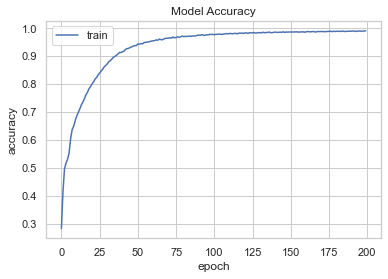

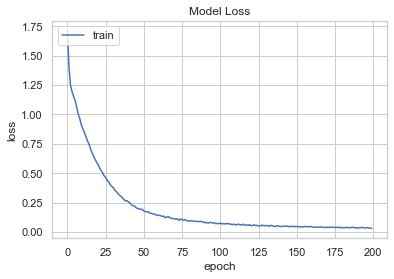

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            461824    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 99.451%


##### Confusion Matrix

15840 is the number of test value in kfold_val / train_test_split


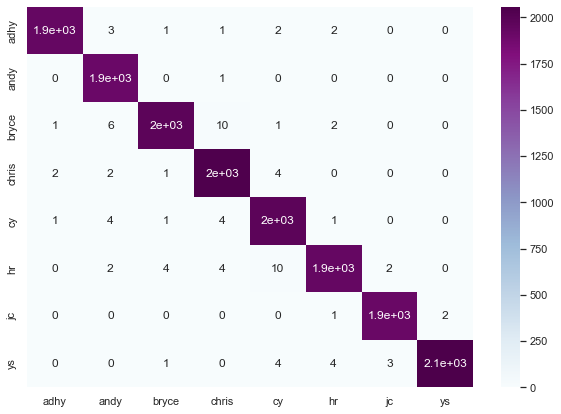

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

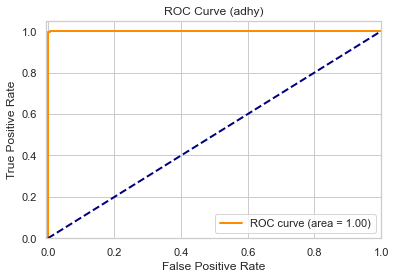

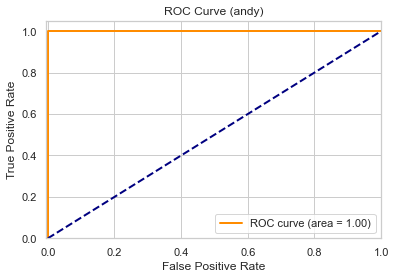

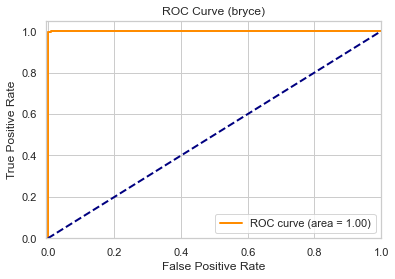

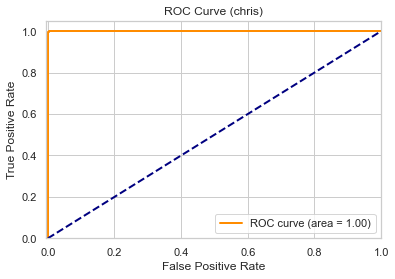

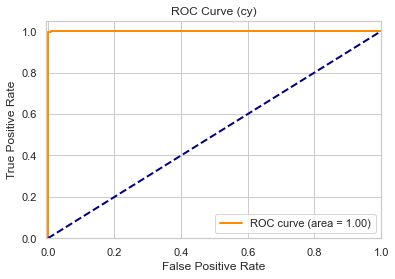

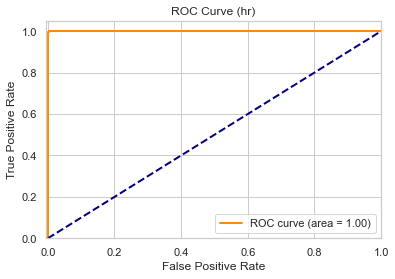

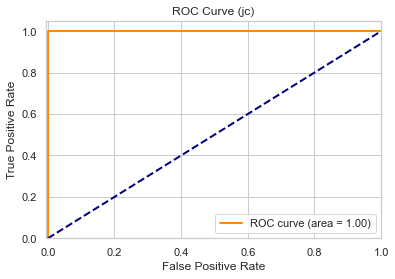

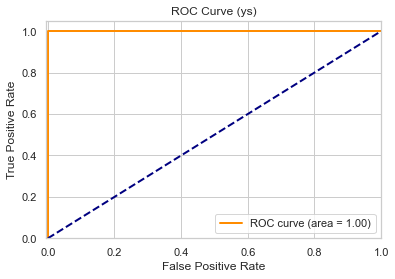

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

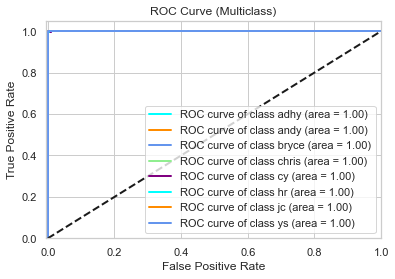

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

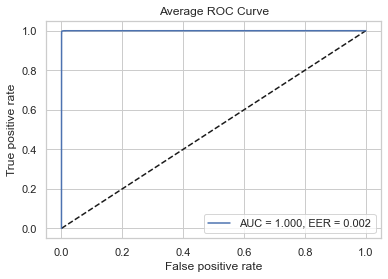

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [24]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (79200, 194)
Y | Classes  | Dataset Shape: (79200, 8)
There are a total of 8 classes.
Epoch 1/200
792/792 [==============================] - 32s 35ms/step - loss: 1.6459 - accuracy: 0.3203
Epoch 2/200
792/792 [==============================] - 28s 35ms/step - loss: 1.2908 - accuracy: 0.4901
Epoch 3/200
792/792 [==============================] - 27s 34ms/step - loss: 1.1934 - accuracy: 0.5242
Epoch 4/200
792/792 [==============================] - 27s 34ms/step - loss: 1.1415 - accuracy: 0.5458
Epoch 5/200
792/792 [==============================] - 27s 34ms/step - loss: 1.0774 - accuracy: 0.5871
Epoch 6/200
792/792 [==============================] - 27s 34ms/step - loss: 1.0189 - accuracy: 0.6101
Epoch 7/200
792/792 [==============================] - 27s 34ms/step - loss: 0.9694 - accuracy: 0.6271
Epoch 8/200
792/792 [==============================] - 27s 34ms/step - l

792/792 [==============================] - 28s 36ms/step - loss: 0.0759 - accuracy: 0.9770
Epoch 78/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0820 - accuracy: 0.9744
Epoch 79/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0762 - accuracy: 0.9761
Epoch 80/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0771 - accuracy: 0.9757
Epoch 81/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0763 - accuracy: 0.9764
Epoch 82/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0742 - accuracy: 0.9765
Epoch 83/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0701 - accuracy: 0.9785
Epoch 84/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0767 - accuracy: 0.9765
Epoch 85/200
792/792 [==============================] - 28s 35ms/step - loss: 0.0704 - accuracy: 0.9788
Epoch 86/200
792/792 [==============================] - 28s 35ms/step - loss:

792/792 [==============================] - 31s 39ms/step - loss: 0.0341 - accuracy: 0.9898
Epoch 156/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0442 - accuracy: 0.9870
Epoch 157/200
792/792 [==============================] - 31s 39ms/step - loss: 0.0349 - accuracy: 0.9903
Epoch 158/200
792/792 [==============================] - 32s 41ms/step - loss: 0.0387 - accuracy: 0.9883
Epoch 159/200
792/792 [==============================] - 32s 41ms/step - loss: 0.0371 - accuracy: 0.9892
Epoch 160/200
792/792 [==============================] - 30s 38ms/step - loss: 0.0348 - accuracy: 0.9895
Epoch 161/200
792/792 [==============================] - 29s 37ms/step - loss: 0.0363 - accuracy: 0.9890
Epoch 162/200
792/792 [==============================] - 29s 37ms/step - loss: 0.0392 - accuracy: 0.9887
Epoch 163/200
792/792 [==============================] - 33s 41ms/step - loss: 0.0383 - accuracy: 0.9887
Epoch 164/200
792/792 [==============================] - 33s 41ms/ste

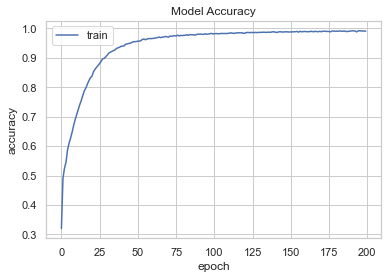

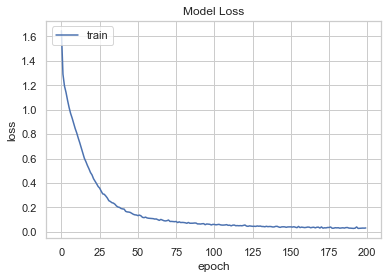

In [25]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [26]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING FOR IR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [27]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [28]:
METHOD = "IR" # identical_random
# METHOD = "DR" # different_random

ACTUAL_DATASET_NAME = "pair_test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set03\\12_pair_IRDR"
RESULT_NAME = "result_" + "set03_12_pair_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T4-RF|VAR.1,T4-NG|VAR.1,T4-I|SD.1,T4-PF|SD.1,T4-RF|SD.1,T4-NG|SD.1,T5-I|0+4.1,T5-PF|0+4.1,T5-RF|0+4.1,T5-NG|0+4.1
0,adhy,quail,0.119654,-0.024004,0.09565,0.080376,0.20003,0.10438,0.304264,0.408644,...,0.080180,0.097463,0.271303,0.300333,0.283161,0.312191,0.616362,0.769361,0.736033,0.889032
1,adhy,quail,0.119654,-0.024004,0.09565,0.080376,0.20003,0.10438,0.304264,0.408644,...,0.000036,0.000034,0.034878,0.034673,0.005993,0.005788,0.344067,0.456247,0.416209,0.528389
2,adhy,quail,0.119654,-0.024004,0.09565,0.080376,0.20003,0.10438,0.304264,0.408644,...,0.009373,0.006345,0.113785,0.096630,0.096813,0.079658,1.008275,1.128276,1.128039,1.248040
3,adhy,quail,0.119654,-0.024004,0.09565,0.080376,0.20003,0.10438,0.304264,0.408644,...,0.012563,0.010132,0.061637,0.050211,0.112083,0.100657,0.375933,0.487393,0.439950,0.551410
4,adhy,quail,0.119654,-0.024004,0.09565,0.080376,0.20003,0.10438,0.304264,0.408644,...,0.009327,0.004563,0.079918,0.050886,0.096579,0.067547,0.423579,0.575900,0.535566,0.687887


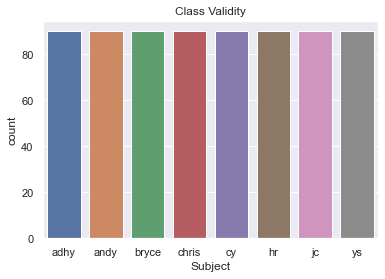

In [29]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [30]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [31]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

ir_result = "Accuracy of the Model for IR dataset: " + str(match_header)
print(ir_result)

Accuracy of the Model for IR dataset: 390/720 (54.166666666666664%)


# LIVE TESTING FOR DR
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [32]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [33]:
# METHOD = "IR" # identical_random
METHOD = "DR" # different_random

ACTUAL_DATASET_NAME = "pair_test_" + METHOD
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

RESULT_DIR_NAME = "dataset\set03\\12_pair_IRDR"
RESULT_NAME = "result_" + "set03_12_pair_" + METHOD
RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

,Subject,Sequence,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,T2-RF|1+2,T2-NG|1+2,T2-D|2,T2-I|2+3,T2-PF|2+3,T2-RF|2+3,T2-NG|2+3,T2-D|3,T2-I|3+4,T2-PF|3+4,T2-RF|3+4,T2-NG|3+4,T2-D|4,T2-D|S,T2-I|S,T2-PF|S,T2-RF|S,T2-NG|S,T2-D|M,T2-I|M,T2-PF|M,T2-RF|M,T2-DT-M,T2-D|VAR,T2-I|VAR,T2-PF|VAR,T2-RF|VAR,T2-DT-VAR,T2-D|SD,T2-I|SD,T2-PF|SD,T2-RF|SD,T2-NG|SD,T3-I|0+2,T3-PF|0+2,T3-RF|0+2,T3-NG|0+2,T3-I|1+3,T3-PF|1+3,T3-RF|1+3,T3-NG|1+3,T3-I|2+4,T3-PF|2+4,T3-RF|2+4,T3-NG|2+4,T3-I|S,T3-PF|S,T3-RF|S,T3-NG|S,T3-I|M,T3-PF|M,T3-RF|M,T3-NG|M,T3-I|VAR,T3-PF|VAR,T3-RF|VAR,T3-NG|VAR,T3-I|SD,T3-PF|SD,T3-RF|SD,T3-NG|SD,T4-I|0+3,T4-PF|0+3,T4-RF|0+3,T4-NG|0+3,T4-I|1+4,T4-PF|1+4,T4-RF|1+4,T4-NG|1+4,T4-I|S,T4-PF|S,T4-RF|S,T4-NG|S,T4-I|M,T4-PF|M,T4-RF|M,T4-NG|M,T4-I|VAR,T4-PF|VAR,T4-RF|VAR,T4-NG|VAR,T4-I|SD,T4-PF|SD,T4-RF|SD,T4-NG|SD,T5-I|0+4,T5-PF|0+4,T5-RF|0+4,T5-NG|0+4,T2-D|0.1,T2-I|0+1.1,T2-PF|0+1.1,T2-RF|0+1.1,T2-NG|0+1.1,T2-D|1.1,T2-I|1+2.1,T2-PF|1+2.1,T2-RF|1+2.1,T2-NG|1+2.1,T2-D|2.1,T2-I|2+3.1,T2-PF|2+3.1,T2-RF|2+3.1,T2-NG|2+3.1,T2-D|3.1,T2-I|3+4.1,T2-PF|3+4.1,T2-RF|3+4.1,T2-NG|3+4.1,T2-D|4.1,T2-D|S.1,T2-I|S.1,T2-PF|S.1,T2-RF|S.1,T2-NG|S.1,T2-D|M.1,T2-I|M.1,T2-PF|M.1,T2-RF|M.1,T2-DT-M.1,T2-D|VAR.1,T2-I|VAR.1,T2-PF|VAR.1,T2-RF|VAR.1,T2-DT-VAR.1,T2-D|SD.1,T2-I|SD.1,T2-PF|SD.1,T2-RF|SD.1,T2-NG|SD.1,T3-I|0+2.1,T3-PF|0+2.1,T3-RF|0+2.1,T3-NG|0+2.1,T3-I|1+3.1,T3-PF|1+3.1,T3-RF|1+3.1,T3-NG|1+3.1,T3-I|2+4.1,T3-PF|2+4.1,T3-RF|2+4.1,T3-NG|2+4.1,T3-I|S.1,T3-PF|S.1,T3-RF|S.1,T3-NG|S.1,T3-I|M.1,T3-PF|M.1,T3-RF|M.1,T3-NG|M.1,T3-I|VAR.1,T3-PF|VAR.1,T3-RF|VAR.1,T3-NG|VAR.1,T3-I|SD.1,T3-PF|SD.1,T3-RF|SD.1,T3-NG|SD.1,T4-I|0+3.1,T4-PF|0+3.1,T4-RF|0+3.1,T4-NG|0+3.1,T4-I|1+4.1,T4-PF|1+4.1,T4-RF|1+4.1,T4-NG|1+4.1,T4-I|S.1,T4-PF|S.1,T4-RF|S.1,T4-NG|S.1,T4-I|M.1,T4-PF|M.1,T4-RF|M.1,T4-NG|M.1,T4-I|VAR.1,T4-PF|VAR.1,T4-RF|VAR.1,T4-NG|VAR.1,T4-I|SD.1,T4-PF|SD.1,T4-RF|SD.1,T4-NG|SD.1,T5-I|0+4.1,T5-PF|0+4.1,T5-RF|0+4.1,T5-NG|0+4.1
0,adhy,locos,0.104157,0.119091,0.223248,0.199206,0.303363,0.080115,0.151554,0.231669,0.264561,0.344676,0.113006,-0.041006,0.072001,0.039679,0.152686,0.080685,0.039524,0.120209,0.159066,0.239751,0.119543,0.497506,0.269163,0.647126,0.662512,1.040475,0.099501,0.067291,0.161782,0.165628,0.260119,0.000334,0.007428,0.00615,0.00894,0.006992,0.018273,0.086183,0.078425,0.094554,0.083619,0.35076,0.454917,0.463766,0.567924,0.223555,0.30367,0.30424,0.384355,0.079203,0.192209,0.198745,0.311752,0.653518,0.950796,0.966752,1.26403,0.217839,0.316932,0.322251,0.421343,0.01846,0.017386,0.017802,0.017432,0.135869,0.131855,0.133425,0.132031,0.422761,0.526918,0.503446,0.607603,0.343764,0.423878,0.463306,0.543421,0.766524,0.950796,0.966752,1.151024,0.383262,0.475398,0.483376,0.575512,0.00312,0.005309,0.000806,0.00206,0.055859,0.07286,0.028383,0.045383,0.542969,0.647126,0.662512,0.766669,0.152463,-0.064295,0.088169,0.063572,0.216036,0.127867,0.063834,0.191701,0.191828,0.319695,0.127994,-0.016001,0.111994,0.080047,0.208041,0.096048,-0.024611,0.071437,0.104409,0.200457,0.129020,0.633393,-0.041072,0.463300,0.439857,0.944229,0.126679,-0.010268,0.115825,0.109964,0.236057,0.000403,0.002883,0.002836,0.003260,0.003149,0.020073,0.053693,0.053251,0.057096,0.056120,0.127407,0.279870,0.255401,0.407864,0.175828,0.303695,0.271876,0.399743,0.055436,0.183430,0.184456,0.312450,0.358671,0.766995,0.711733,1.120057,0.119557,0.255665,0.237244,0.373352,0.003670,0.004055,0.002158,0.002798,0.060579,0.063681,0.046452,0.052899,0.239400,0.391864,0.335448,0.487911,0.247265,0.375132,0.376285,0.504152,0.486665,0.766995,0.711733,0.992063,0.243332,0.383498,0.355866,0.496032,0.000031,0.000140,0.000834,1.318750e-04,0.005561,0.011831,0.028876,0.011484,0.310837,0.463300,0.439857,0.592320
1,adhy,locos,0.104157,0.119091,0.223248,0.199206,0.303363,0.080115,0.151554,0.231669,0.264561,0.344676,0.113006,-0.041006,0.072001,0.039679,0.152686,0.080685,0.039524,0.120209,0.159066,0.239751,0.119543,0.497506,0.269163,0.647126,0.662512,1.040475,0.099501,0.067291,0.161782,0.165628,0.260119,0.000334

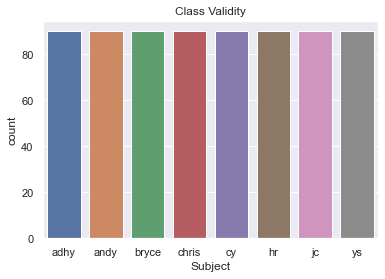

In [34]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [35]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [36]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

dr_result = "Accuracy of the Model for DR dataset: " + str(match_header)
print(dr_result)

Accuracy of the Model for DR dataset: 338/720 (46.94444444444444%)


#### RESULT

In [37]:
print(ir_result)
print(dr_result)

Accuracy of the Model for IR dataset: 390/720 (54.166666666666664%)
Accuracy of the Model for DR dataset: 338/720 (46.94444444444444%)


In [38]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 06:08:10
